In [1]:
import pandas as pd
import numpy as np
import pandahouse as ph
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import hashlib
import swifter

from tqdm.auto import tqdm

In [2]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20220620',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

При этом метод сам по себе очень прост. Что это за метрика такая?

Считаем общий CTR в контрольной группе  𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙=𝑠𝑢𝑚(𝑙𝑖𝑘𝑒𝑠)/𝑠𝑢𝑚(𝑣𝑖𝑒𝑤𝑠) 
Посчитаем в обеих группах поюзерную метрику  𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠 
После чего сравним  t-тестом отличия в группах по метрике 𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠  
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.

Задача

- Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
- Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

## 1) Тест между группами 0 и 3

In [3]:
query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-05-24' and '2022-05-30'
    and exp_group in (0, 3)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [4]:
df.head(1)

,exp_group,user_id,likes,views,ctr
0,3,115383,9,30,0.3


In [5]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
0,9999,9999,9999,9999
3,10049,10049,10049,10049


### Проведем визуальную оценку распределений ctr для групп 0 и 3

In [6]:
sns.set(rc={'figure.figsize':(10,6)})

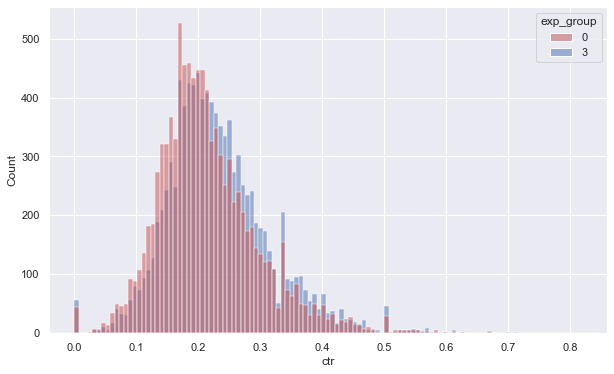

In [7]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

###  Проведем t тест

In [8]:
t_ctr, pvalue_ctr = stats.ttest_ind(df[df.exp_group == 0].ctr, 
                         df[df.exp_group == 3].ctr,
                         equal_var=False)


if pvalue_ctr > 0.05:
    print('Нет статистически значимой разницы','\nt-критерий = ', t_ctr,'\np-value =', pvalue_ctr)
else:
    print('Есть статистически значимая разница','\nt-критерий = ', t_ctr,'\np-value =', pvalue_ctr)

Есть статистически значимая разница 
t-критерий =  -13.896870721904069 
p-value = 1.055849414662529e-43


### Посчитаем по методу линеаризованных лайков и применим t тест

In [9]:
ctr_control_0 = df[df.exp_group==0].likes.sum()/df[df.exp_group==0].views.sum()
ctr_control_0

0.20823612262916305

In [10]:
df['linearized_likes'] = df.apply(lambda row: row['likes']-row['views']*ctr_control_0, axis=1)

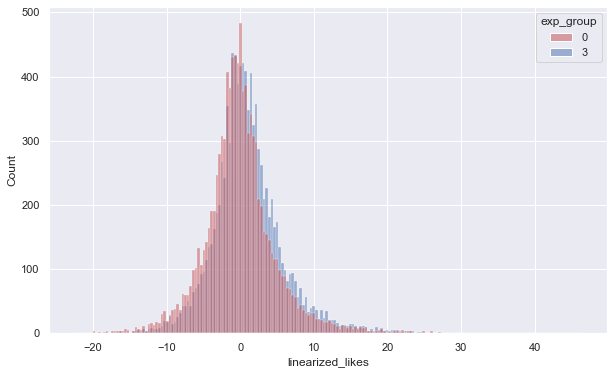

In [11]:
groups = sns.histplot(data = df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [12]:
# визуально графики стали более идентичными

In [13]:
t_linearized_likes, pvalue_linearized_likes = stats.ttest_ind(df[df.exp_group == 0].linearized_likes, 
                                                              df[df.exp_group == 3].linearized_likes,
                                                              equal_var=False)


if pvalue_linearized_likes > 0.05:
    print('Нет статистически значимой разницы','\nt-критерий = ', t_linearized_likes,'\np-value =', pvalue_linearized_likes)
else:
    print('Есть статистически значимая разница','\nt-критерий = ', t_linearized_likes,'\np-value =', pvalue_linearized_likes)

Есть статистически значимая разница 
t-критерий =  -15.214995460903827 
p-value = 5.4914249479690016e-52


In [14]:
pvalue_linearized_likes < pvalue_ctr 

True

### Pvalue стало меньше и есть статистически значимая разница в обоих расчетах

## 2) Тест между группами 1 и 2

In [15]:
query = '''
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-05-24' and '2022-05-30'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

In [16]:
df.head(1)

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.2


In [17]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


### Проведем визуальную оценку распределений ctr для групп 1 и 2


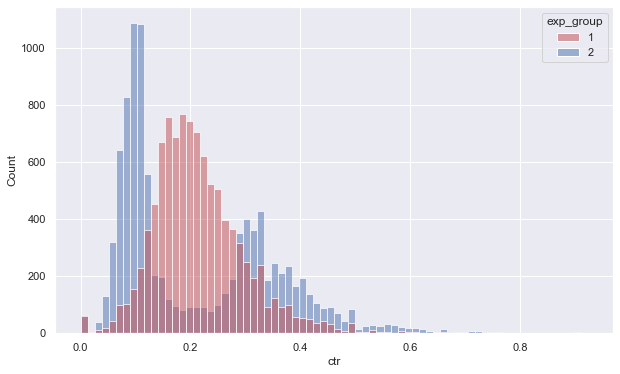

In [18]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

###  Проведем t тест

In [19]:
t_ctr, pvalue_ctr = stats.ttest_ind(df[df.exp_group == 1].ctr, 
                         df[df.exp_group == 2].ctr,
                         equal_var=False)


if pvalue_ctr > 0.05:
    print('Нет статистически значимой разницы','\nt-критерий = ', t_ctr,'\np-value =', pvalue_ctr)
else:
    print('Есть статистически значимая разница','\nt-критерий = ', t_ctr,'\np-value =', pvalue_ctr)

Нет статистически значимой разницы 
t-критерий =  0.7094392041270486 
p-value = 0.4780623130874935


### Посчитаем по методу линеаризованных лайков и применим t тест

In [20]:
ctr_control_1 = df[df.exp_group==1].likes.sum()/df[df.exp_group==1].views.sum()
ctr_control_1

0.20802680490126244

In [21]:
df['linearized_likes'] = df.apply(lambda row: row['likes']-row['views']*ctr_control_1, axis=1) 

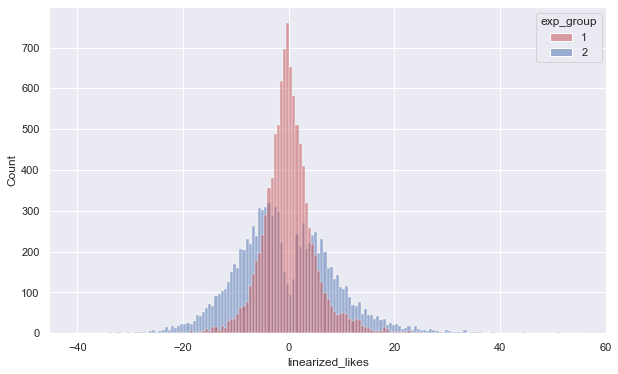

In [22]:
groups = sns.histplot(data = df, 
              x='linearized_likes', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [23]:
# визуально графики стали более идентичными

In [24]:
t_linearized_likes, pvalue_linearized_likes = stats.ttest_ind(df[df.exp_group == 1].linearized_likes, 
                                                              df[df.exp_group == 2].linearized_likes,
                                                              equal_var=False)


if pvalue_linearized_likes > 0.05:
    print('Нет статистически значимой разницы','\nt-критерий = ', t_linearized_likes,'\np-value =', pvalue_linearized_likes)
else:
    print('Есть статистически значимая разница','\nt-критерий = ', t_linearized_likes,'\np-value =', pvalue_linearized_likes)

Есть статистически значимая разница 
t-критерий =  6.122579994775973 
p-value = 9.439432187037712e-10


In [25]:
pvalue_linearized_likes < pvalue_ctr 

True

### Pvalue стало меньше, и появилась статистически значимая разница в методе линеаризованных лайков:)